# Deep_Learning_from_Scratch_2 - part5

#### 딥러닝의 기본적인 내용을 정리하였습니다. 밑바닥부터 시작하는 딥러닝2(사이토 고키 지음)을 참고하였습니다. 

## 6. 게이트가 추가된 RNN
#### - RNN은 시계열 데이터에서 장기 의존 관계를 잘 학습할 수 없어서 성능이 좋지 못함
#### - LSTM / GRU -> 게이트 포함

### 6.1 RNN의 문제점
#### - RNN은 시계열 데이터의 장기 의존 관계를 학습하기 어려움 -> 기울기 소실, 폭발이 원인

#### 6.1.1 RNN 복습
#### 6.1.2 기울기 소실 또는 기울기 폭발
#### - RNN 계층이 과거 방향으로 '의미 있는 기울기'를 전달함으로써 시간 방향의 의존 관계를 학습 
#### - 기울기는 학습해야 할 의미가 있는 정보가 들어 있고, 그것을 과거로 전달함으로써 장기 의존 관계를 학습
#### - 하지만 해당 기울기가 중간에 사그라들면, 가중치 매개변수는 전혀 갱신되지 않게 되고 장기 의존 관계를 학습할 수 없게 됨
#### - RNN에서는 기울기 소실 또는 기울기 폭발 발생 가능성 매우 높음

#### 6.1.3 기울기 소실과 기울기 폭발의 원인
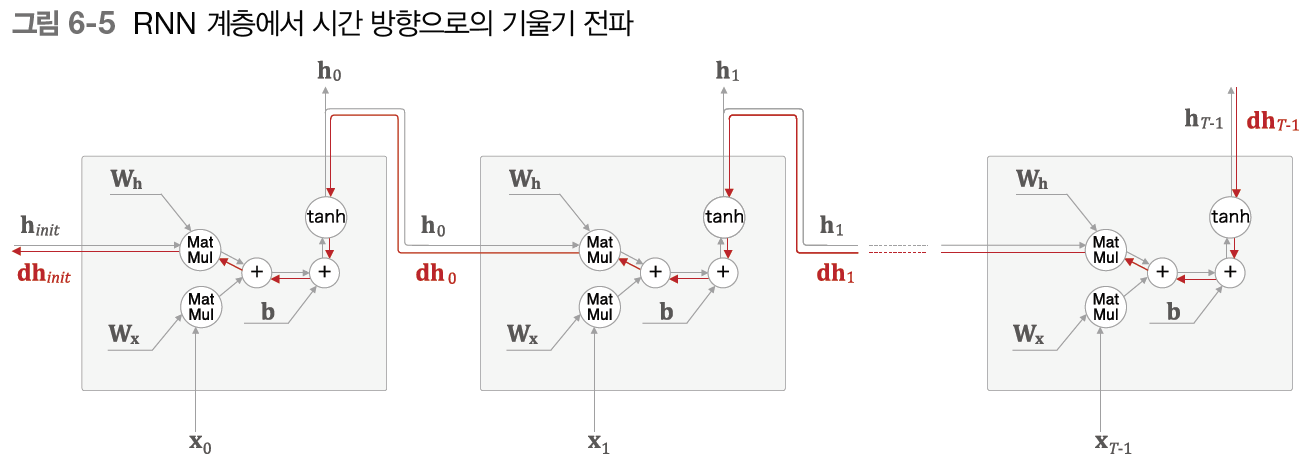
#### - tanh 함수의 gradient의 특징으로 인해 역전파의 기울기가 tanh 노드를 지날 때마다 기울기 값은 지속적으로 감소
#### 6.1.4 기울기 폭발 대책
#### - 기울기 클리핑(gradients clipping)
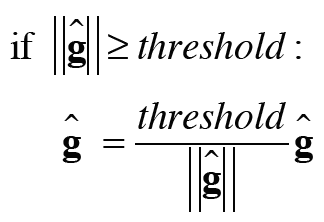

In [1]:
import numpy as np

dW1 = np.random.randn(3,3) * 10
dW2 = np.random.randn(3,3) * 10
grads = [dW1, dW2]
max_norm = 5.0

def clip_grads(grads, max_norm):
    total_norm = 0
    for grad in grads:
        total_norm += np.sum(grad ** 2)
    total_norm = np.sqrt(total_norm)
    
    rate = max_norm / (total_norm + 1e-6)
    if rate < 1 :
        for grad in grads:
            grad *= rage

### 6.2 기울기 소실과 LSTM
#### - 기울기 소실 문제 해결을 위해 아키텍처 수정 

#### 6.2.1 LSTM의 인터페이스
#### - c : 기억 셀 / LSTM 전용 기억 메커니즘 -> 데이터를 자기 자신으로만 (LSTM 계층 내 에서만) 주고 받음
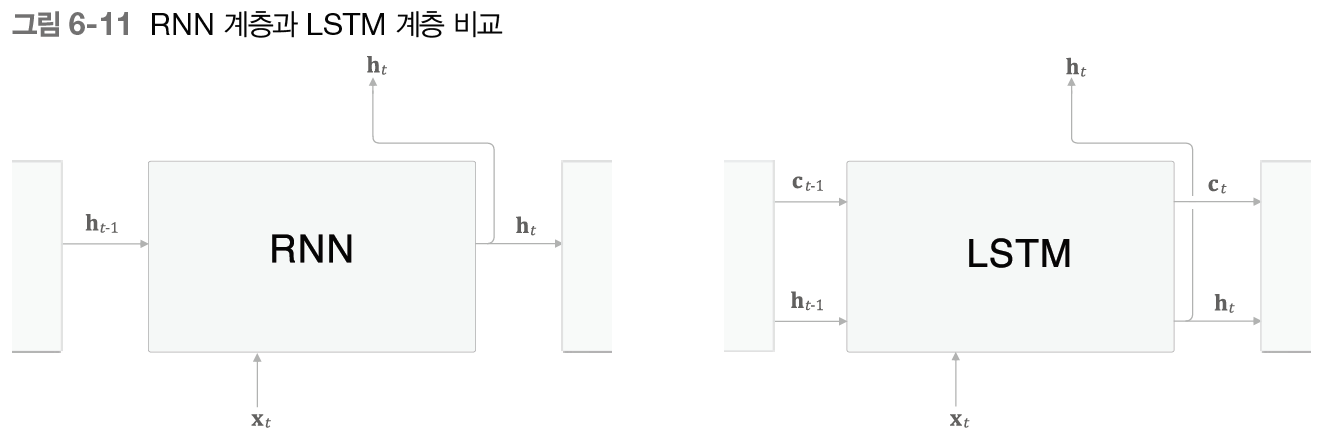
#### 6.2.2 LSTM 계층 조립하기
#### - c_t : 시각 t에서의 LSTM의 기억이 저장, 과거부터 시각 t까지 필요한 모든 정보가 저장
#### - h_t : 은닉 상태, 외부에 출력, c_t를 tanh함수로 변환
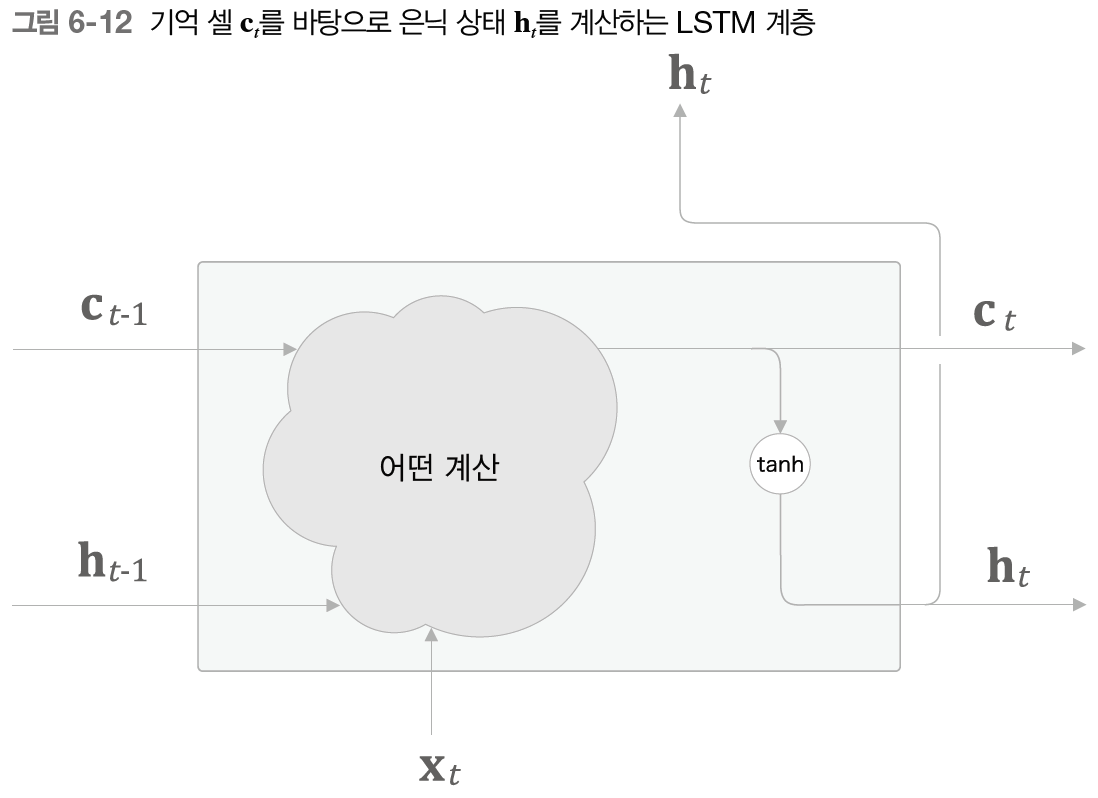
#### - 게이트를 얼마나 열까(0~1 사이 값)는 데이터로부터 학습

#### 6.2.3 output 게이트
#### - output 게이트 : tahn(c_t)의 각 원소에 대해 그것이 다음 시각의 은닉 상태에 얼마나 중요한가를 조정 / 은닉 상태 h_t의 출력을 담당
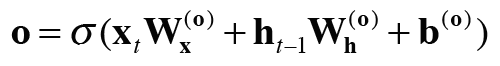
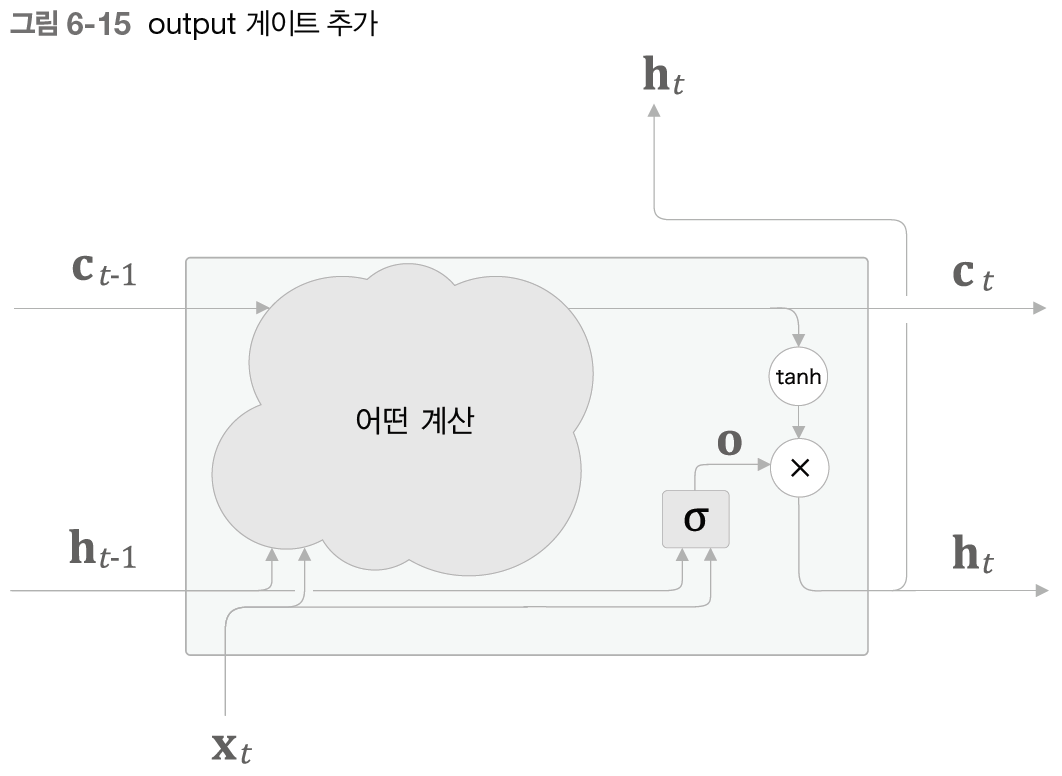
#### - 아다마르 곱(hadamard product) : 원소별 곱
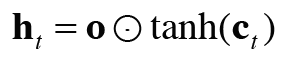

#### 6.2.4 forget 게이트
#### - forget 게이트 : c_t-1의 기억 중에서 불필요한 기억을 잊게 해주는 게이트
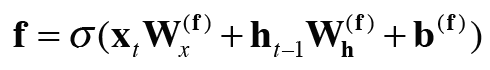
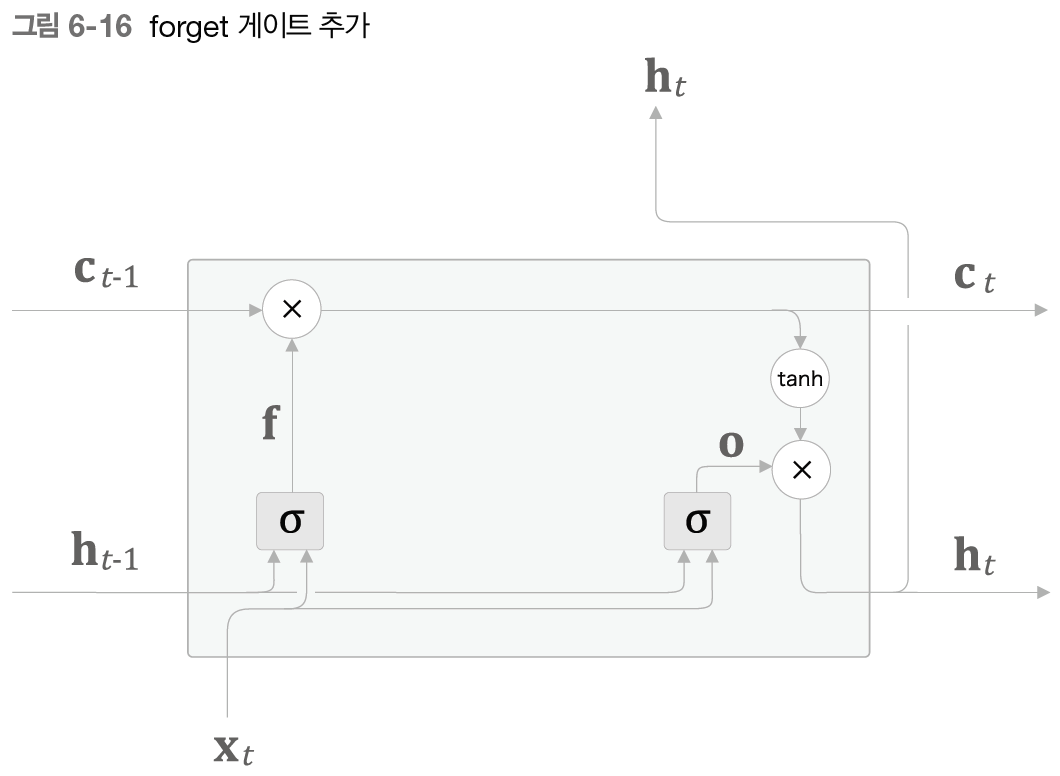

#### 6.2.5 새로운 기억 셀
#### - 새로 기억해야 할 정보를 기억 셀에 추가 / 게이트가 아니며 새로운 정보를 추가하는 것이 목적이기 때문에 시그모이드가 아닌 tanh 활용
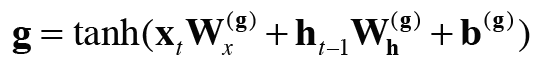
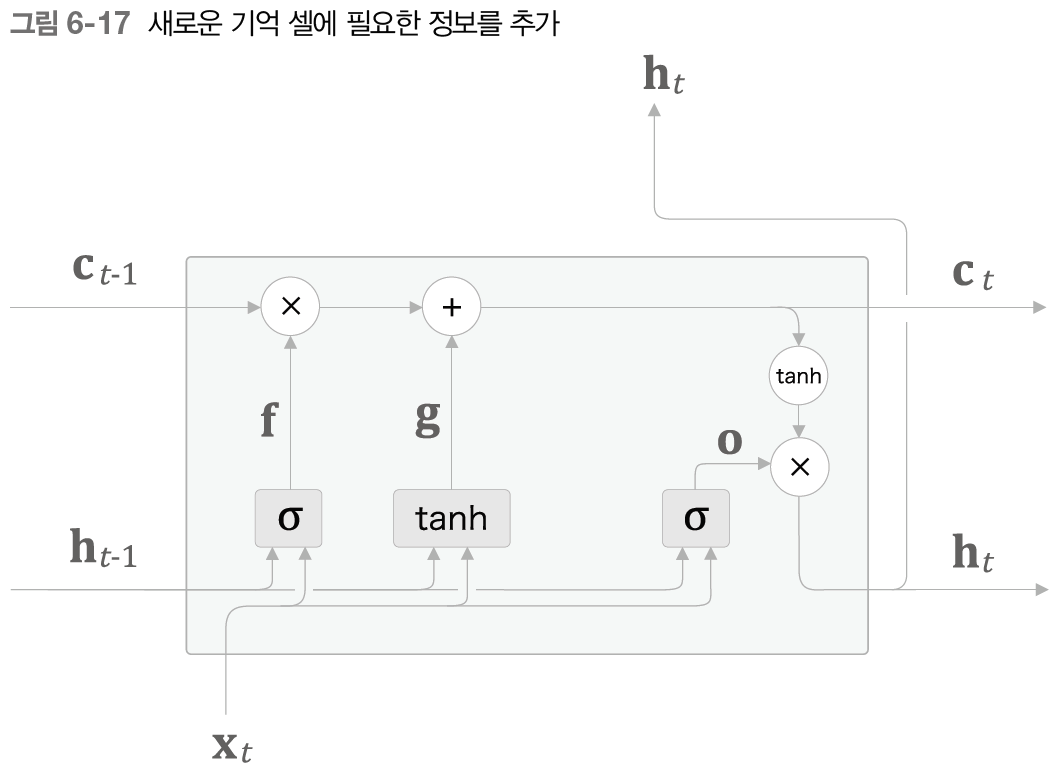

#### 6.2.6 input 게이트
#### - input 게이트 : g의 각 원소가 새로 추가되는 정보로써의 가치가 얼마나 큰 지 판단 / input 게이트에 의해 가중된 정보가 새로 추가
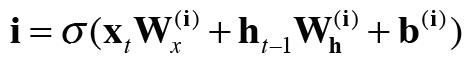
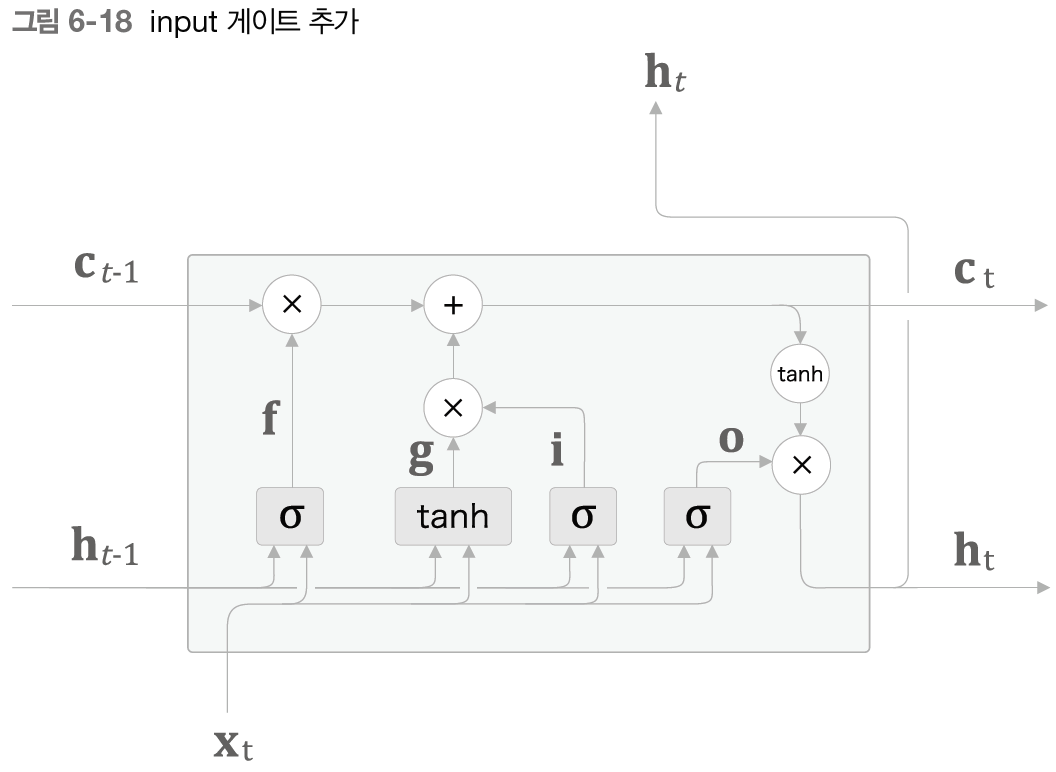

#### 6.2.7 LSTM의 기울기 흐름
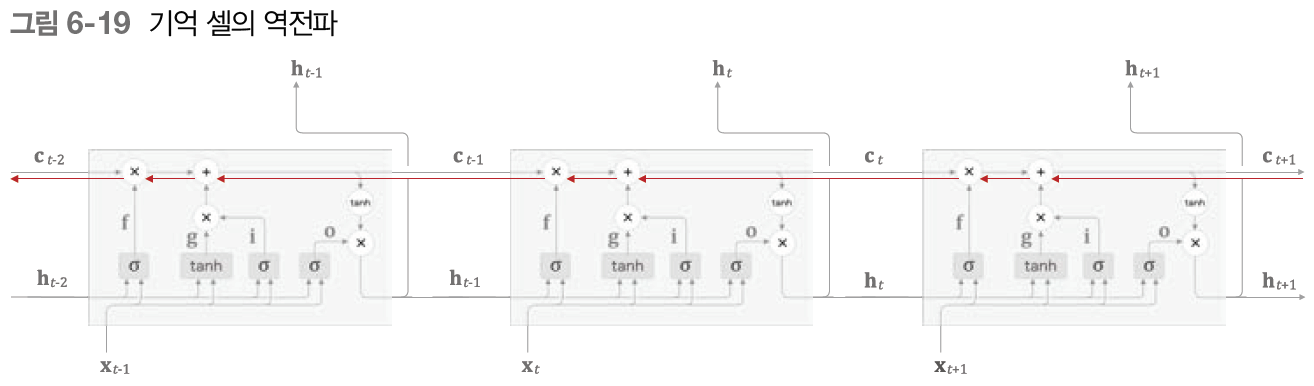
#### - 행렬 곱이 아닌 원소별 곱을 사용하기 때문에 곱셈의 효과가 누적이 되지 않음
#### - 곱하기 계산을 forget 게이트가 제어 / 중요한 정보는 기울기가 약화되지 않은 채 과거 방향으로 전달

### 6.3 LSTM 구현
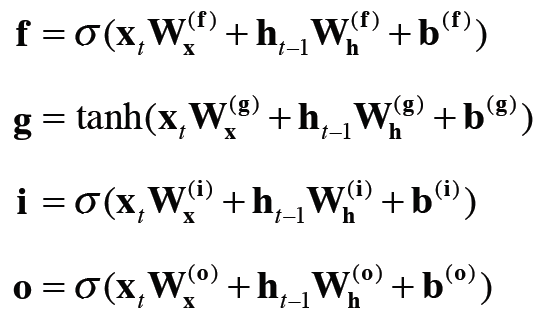
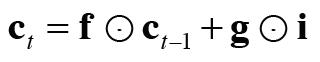
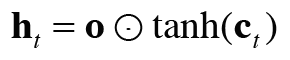
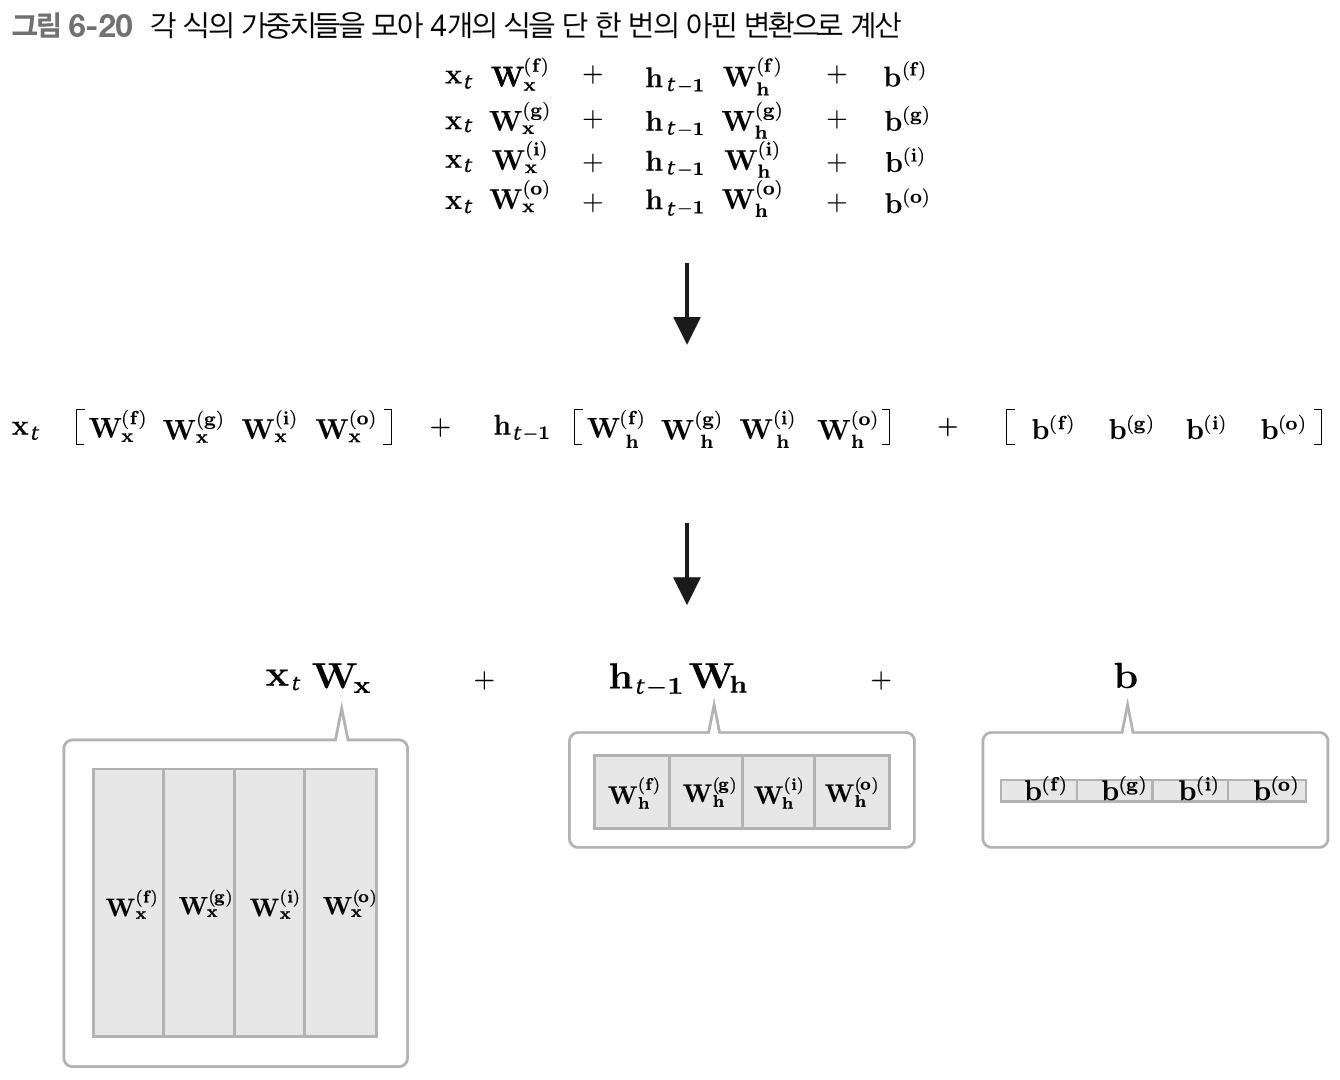
#### - 4개의 아핀 변환을 한 번에 수행 후 slice 노드를 통해 4개의 결과를 꺼내서 사용
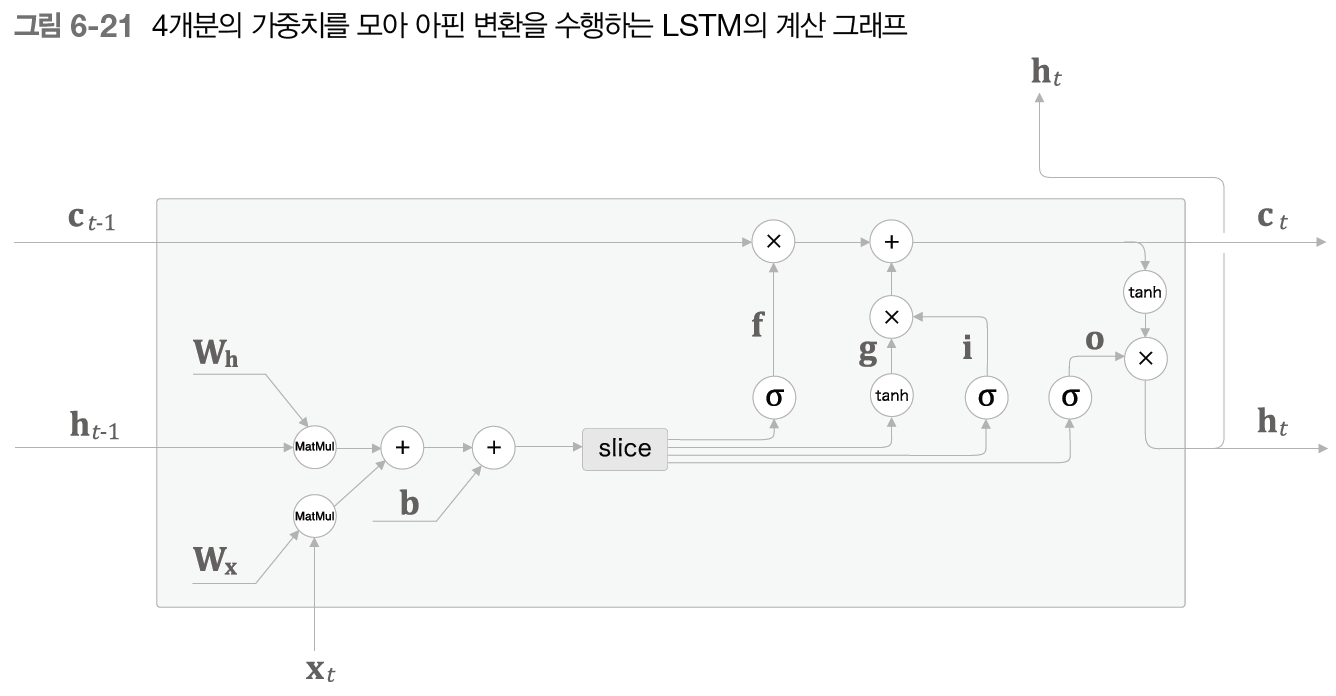
![image.png](attachment:969a2b36-4681-46f4-ab26-dab83689fc2d.png)
![image.png](attachment:b4882da1-7614-4b22-af3e-77206fdb566e.png)

In [3]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None
    
    def forward(self, x, h_prev, c_prev):
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.matmul(x, Wx) + np.matmul(h_prev, Wh) + b
        
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]
        
        f = np.sigmoid(f)
        g = np.tanh(g)
        i = np.sigmoid(i)
        o = np.sigmoid(o)
        
        c_next = f * c_prev + g*i
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        
        return h_next, c_next
    
    

### 6.3.1 Time LSTM 구현
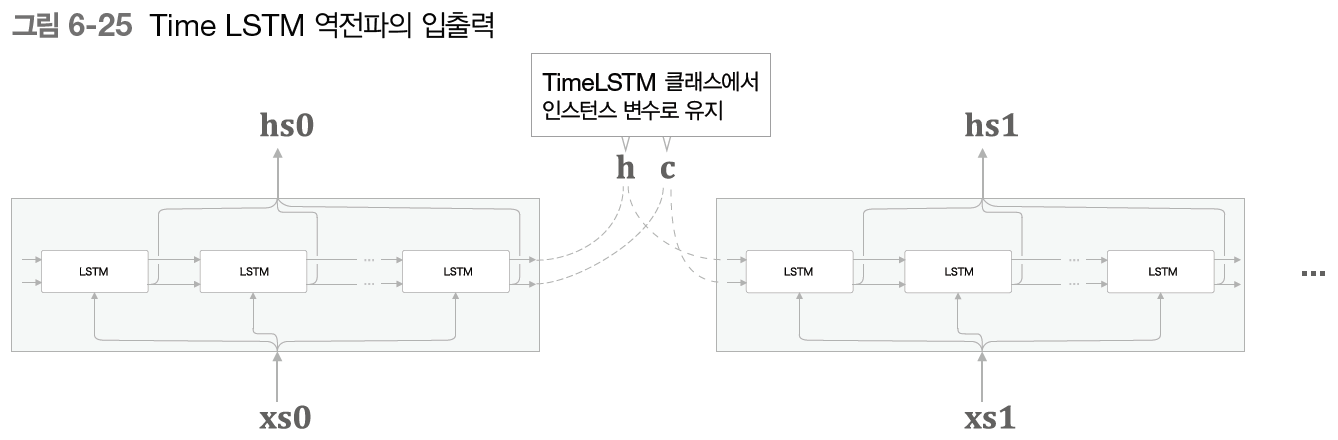

In [4]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.c = None, None
        self.dh = None
        self.stateful = stateful
    
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]
        
        self.layers = []
        hs = np.empty((N, T, H), dtype='f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')
            
        for t in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            h[:, t, :] = self.h
            
            self.layers.append(layer)
        
        return hs
    
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D = Wx.shape[0]

        hs = np.empty((N, T, D), dtype='f')
        dh, dc = 0, 0
        
        grads =[0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh, dc = layer.backward(dhs[:, t, :]+dh, dc)
            dxs[:, t, :] = dx
            for i, grad in enumerate(layer.grads):
                grads[i] += grad
                
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
            self.dh = dh
            return dxs
        
    def set_state(self, h, c=None):
        self.h, self.c = h, c
        
    def reset_state(self):
        self.h, self.c = None, None
    
    

### 6.4 LSTM을 사용한 언어 모델
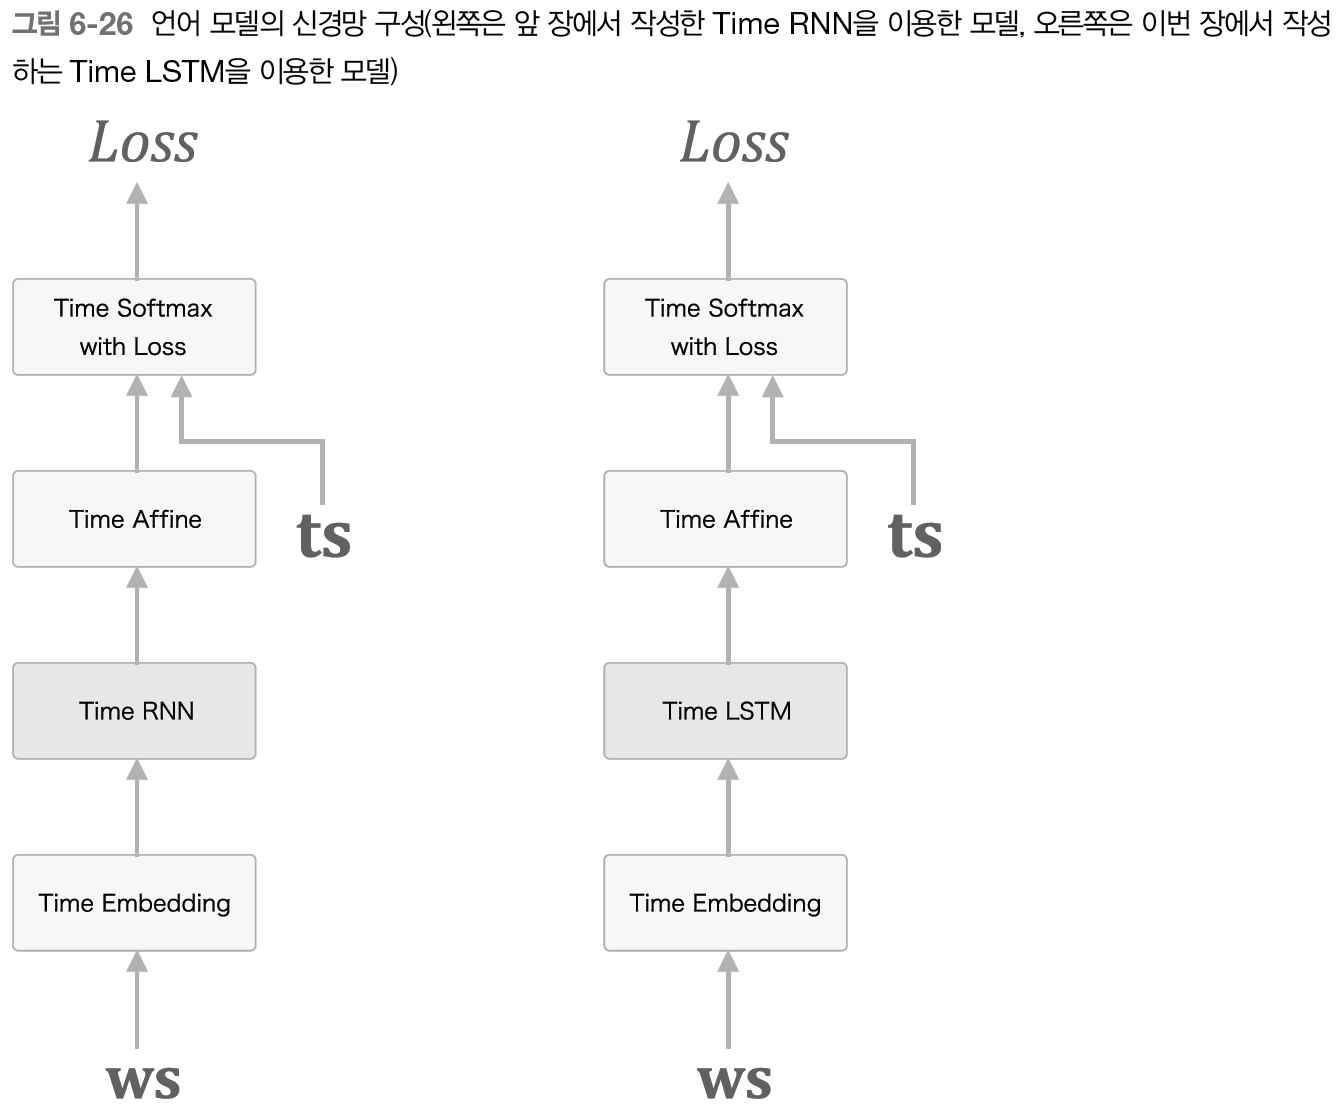

### 6.5 RNNLM 추가 개선
#### 6.5.1 LSTM 계층 다층화
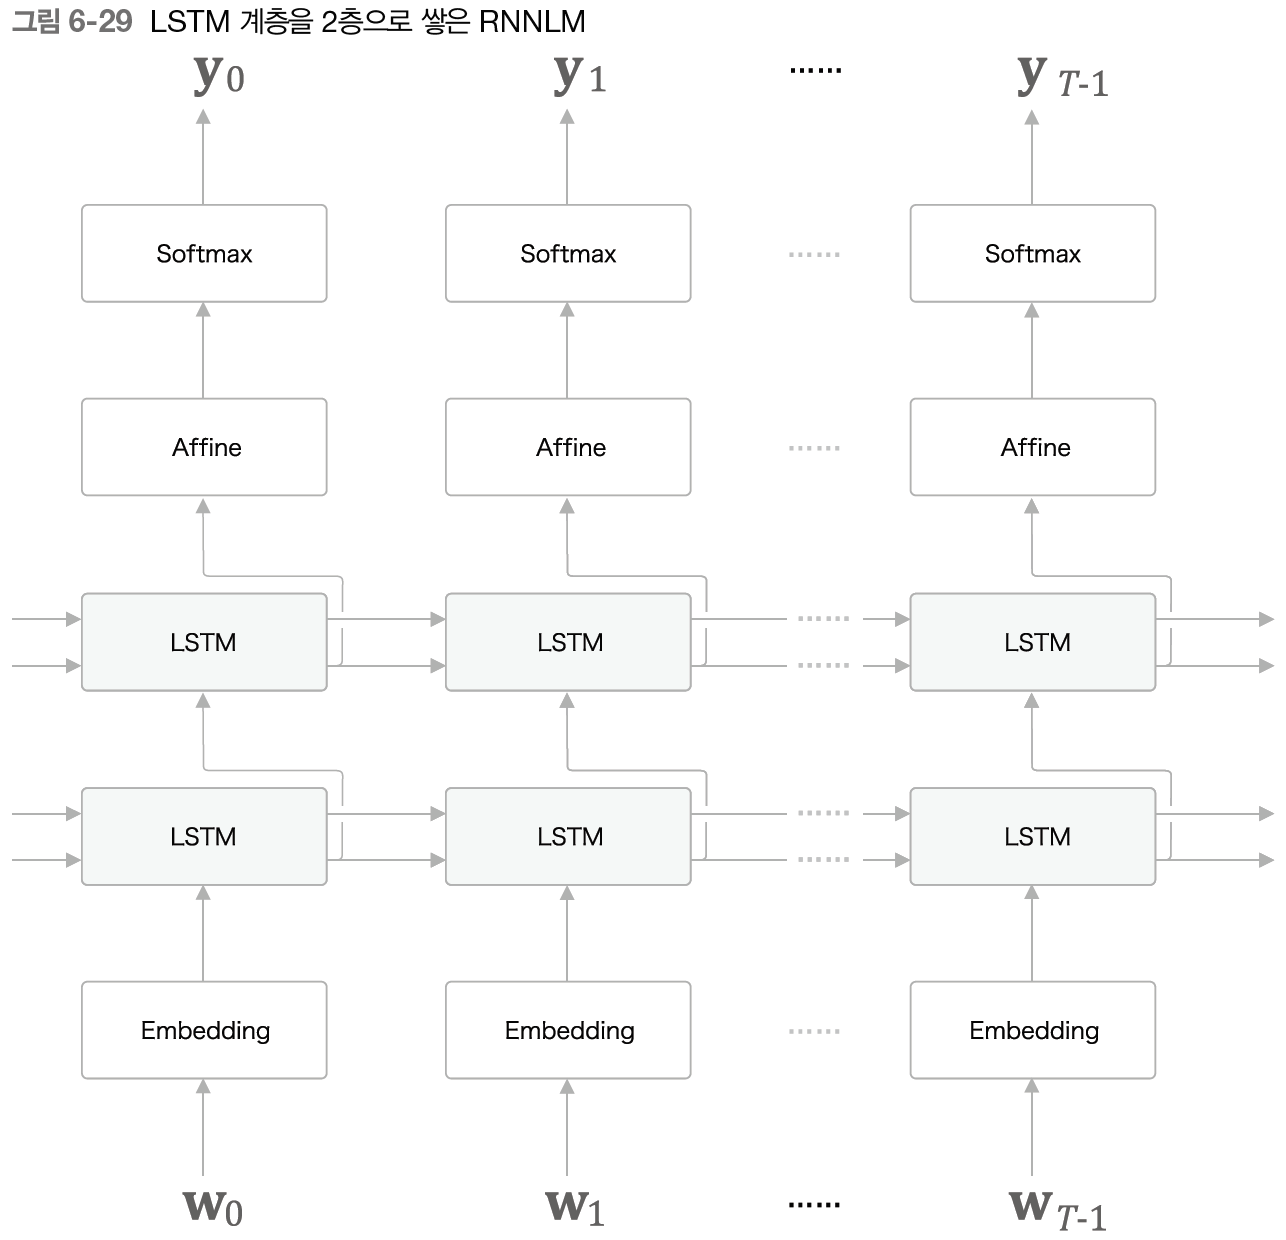
#### - LSTM 계층을 깊게 쌓는 것이 정확도 향상을 이끌 수 있음
#### 6.5.2 드롭아웃에 의한 과적합 억제
#### - 층이 깊어질수록 과적합의 위험 가능성 높아짐 / RNN은 일반 피드포워드 신경망보다 쉽게 과적합이 일어남
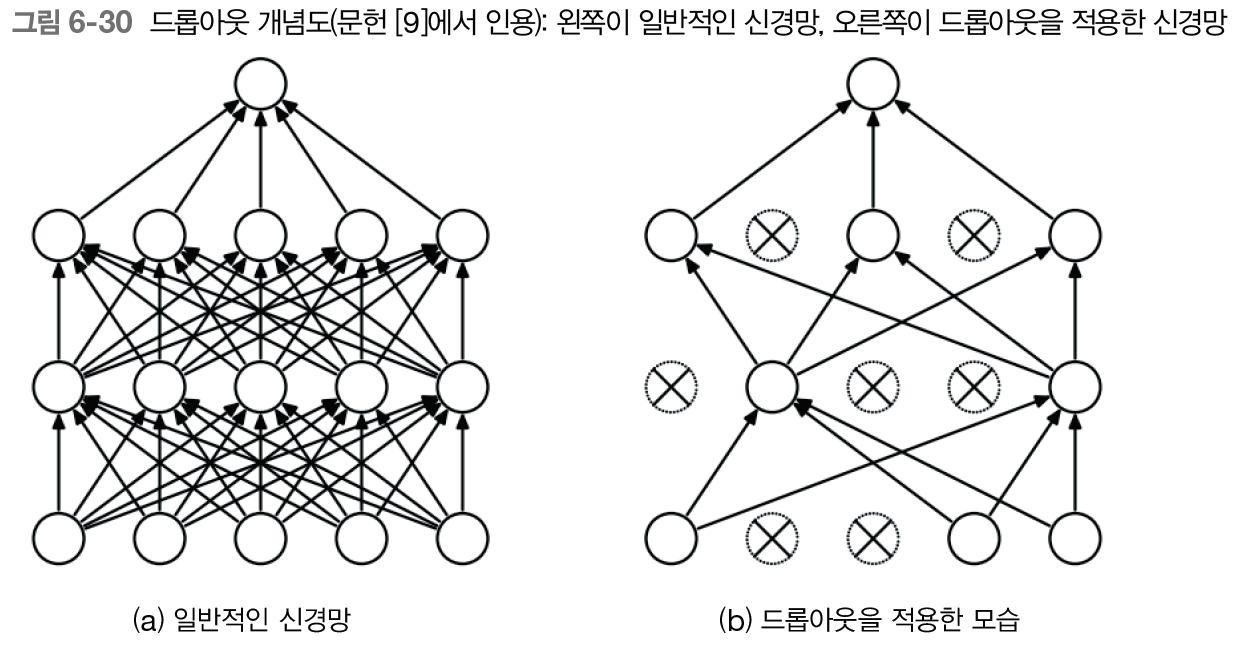
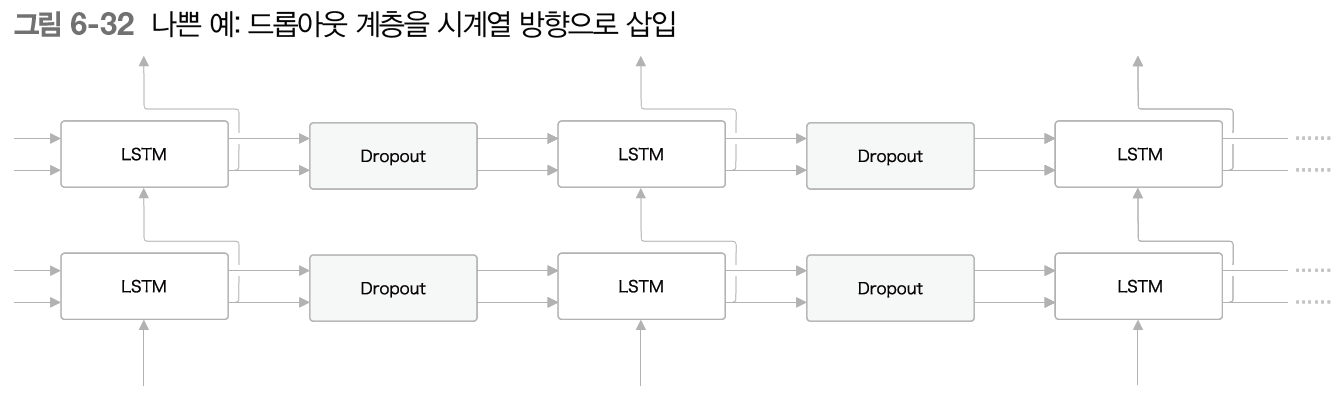
#### - 위와 같은 방향으로 드랍아웃을 추가하면 시간이 흐름에 따라 정보가 사라질 수 있음 / 흐르는 시간에 비례하여 드랍아웃에 의한 노이즈가 추겆ㄱ
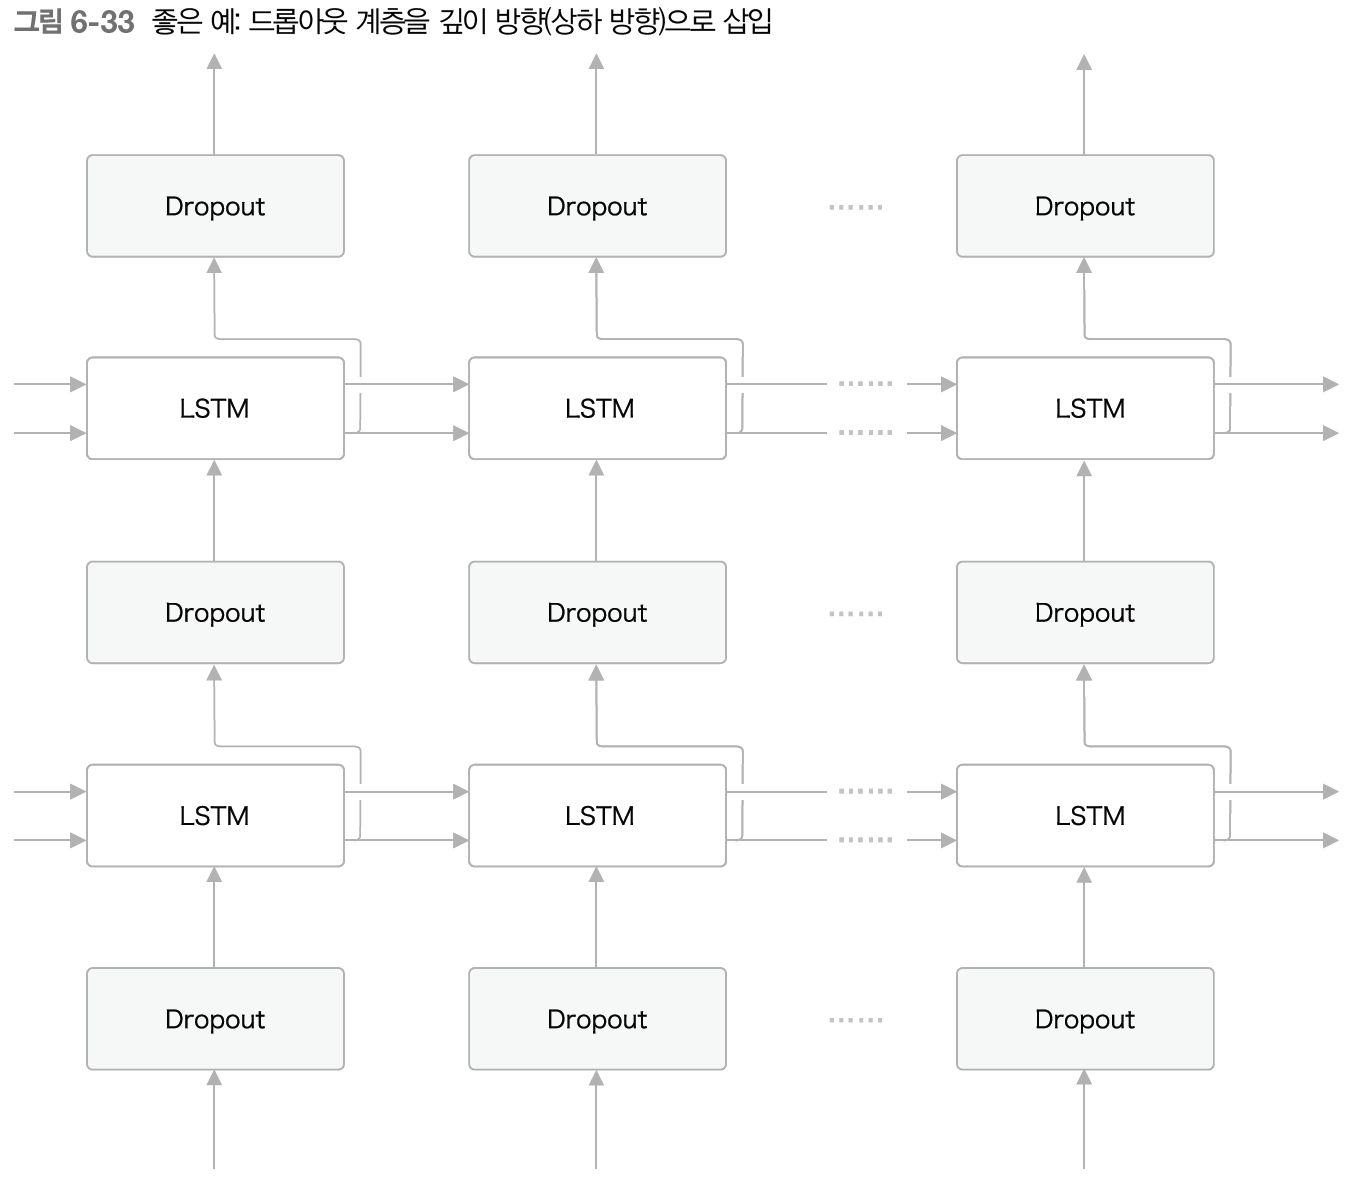
#### - 시간축과는 독립적으로 깊이 방향(상하 방향)에만 영향을 줌
#### - 변형 드롭아웃 : 깊이 방향은 물룬 시간 방향에도 이용 가능 / 언어 모델 정확도 향상에 도움 / 같은 드롭아웃끼리는 같은 마스크(데이터의 통과,차단을 결정하는 이진 형태 페널티)를 이용
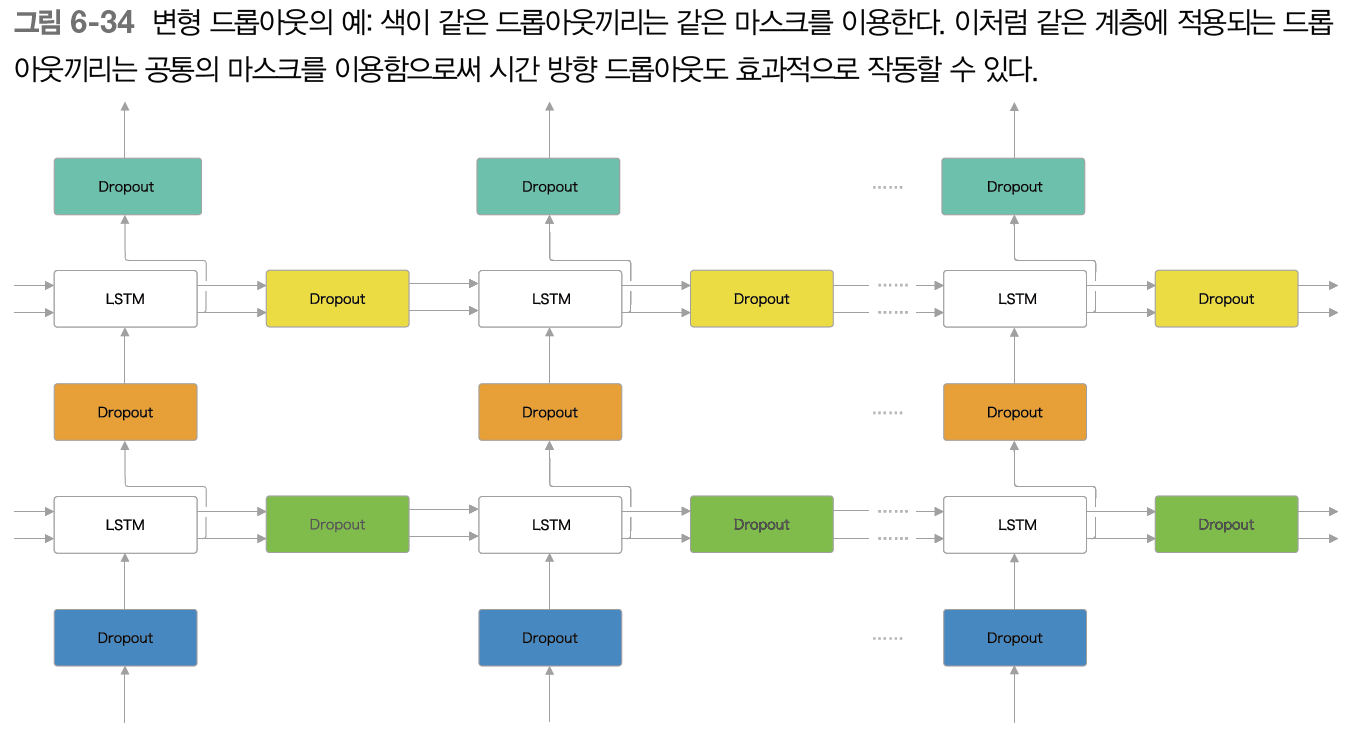
#### 6.5.3 가중치 공유
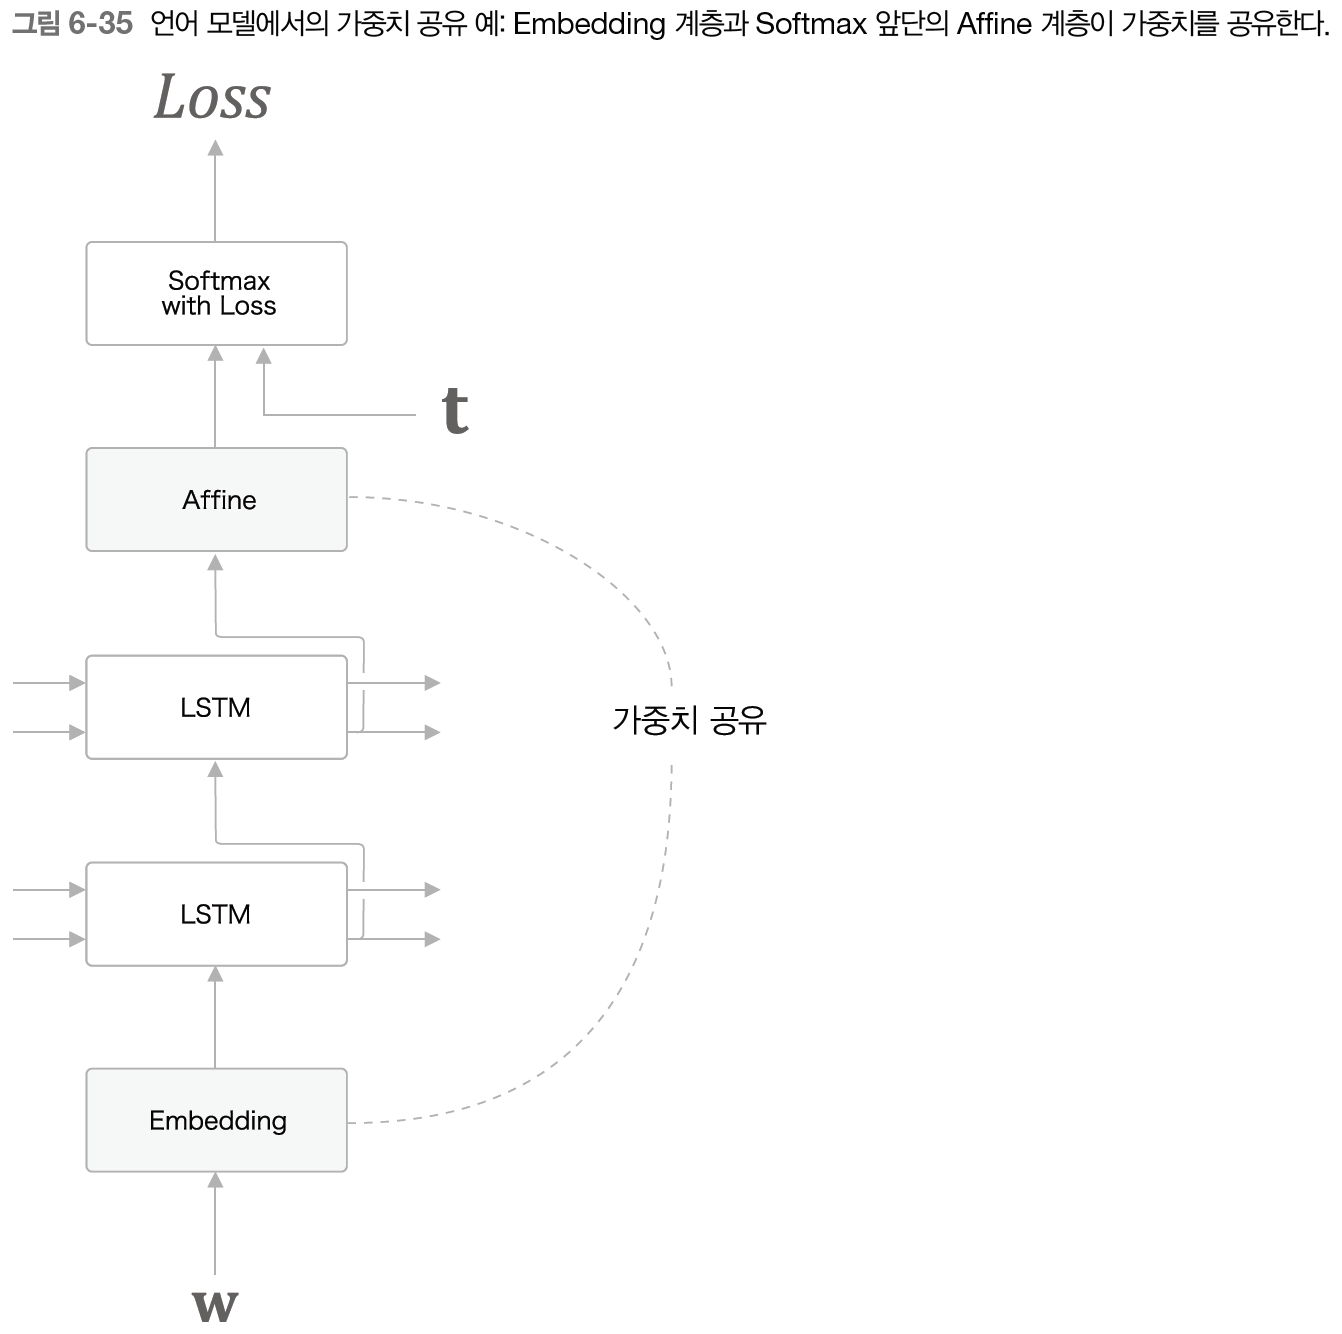
#### - 가중치 공유를 통해 학습하는 매개변수 수가 감소함과 동시에 정확도도 향상

#### 6.5.4 개선된 RNNLM 구현
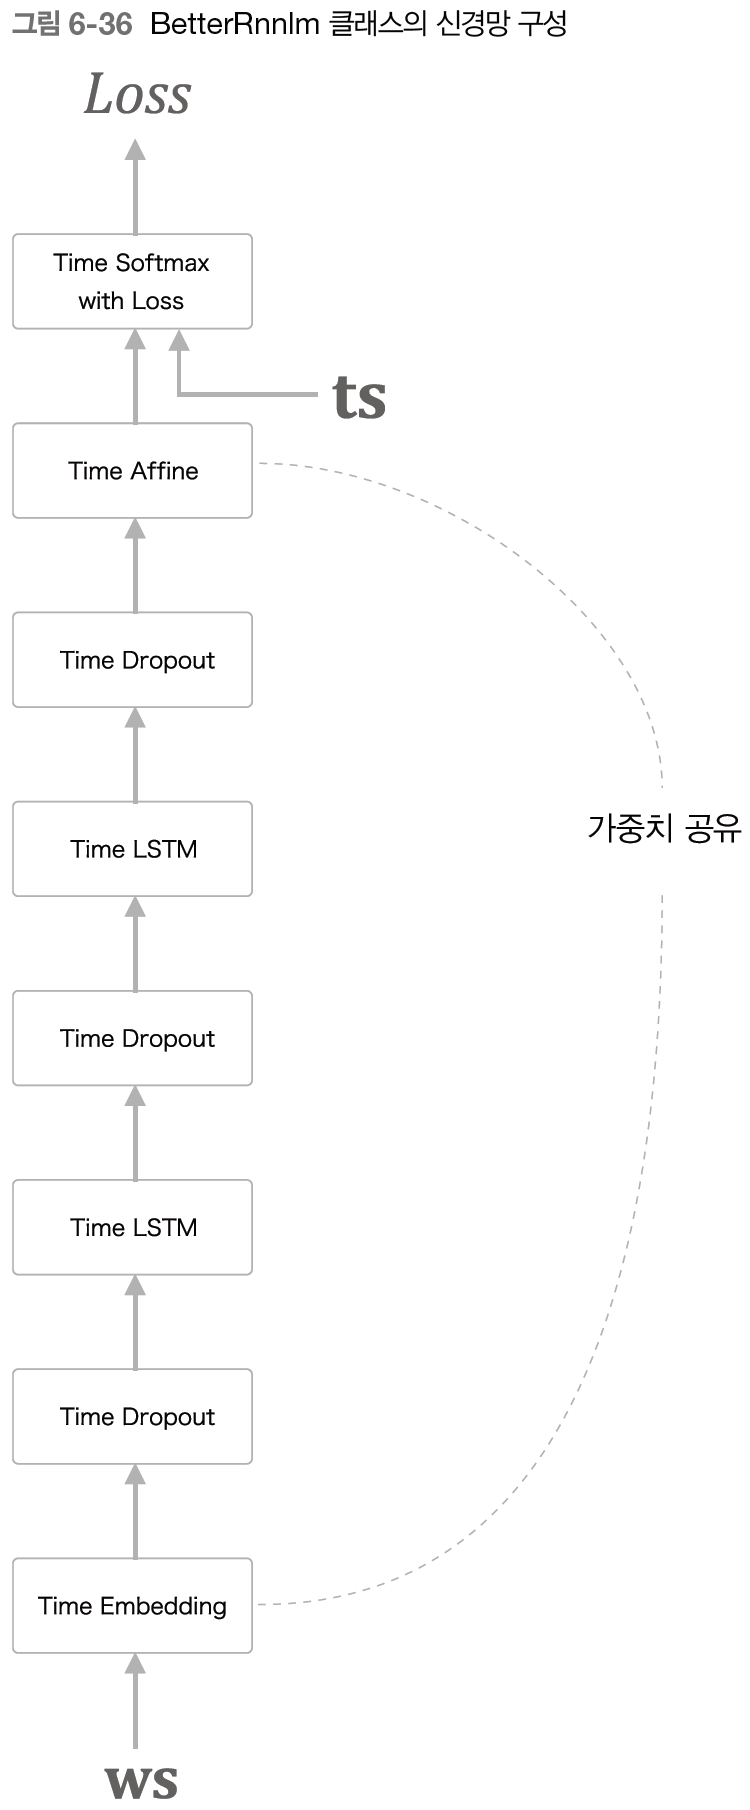